In [12]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle

df = pd.read_csv("aapl.csv", index_col=0)
df.head(3)

,Close/Last,Volume,Open,High,Low
Date,,,,,
04/16/2024,169.38,73711240,171.75,173.76,168.27
04/15/2024,172.69,73531770,175.36,176.63,172.50
04/12/2024,176.55,101670900,174.26,178.36,174.21


In [13]:
open_price = df['Open']
open_price = open_price.iloc[::-1]


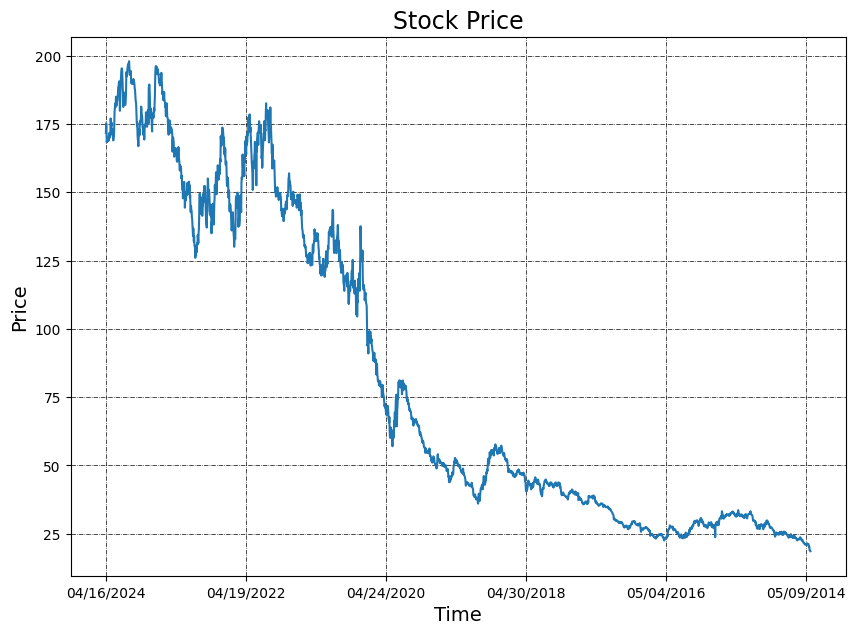

In [14]:
# Plot time series chart
df['Open'].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

# Data Preprocessing

In [15]:
X = []
y = []
for i in range(60,open_price.shape[0]):
    X.append(open_price.iloc[i-60:i])
    y.append(open_price.iloc[i])

X = np.array(X)
y = np.array(y)

print(y.shape)

(2456,)


In [16]:
from sklearn.preprocessing import StandardScaler


standard_scaler = StandardScaler().fit(X)
X_standardized = standard_scaler.transform(X)
X_standardized.shape


(2456, 60)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test= train_test_split(X_standardized,shuffle=False, test_size=0.2, train_size=0.8)
y_train, y_test= train_test_split(y,shuffle=False, test_size=0.2, train_size=0.8)

X_train, X_val= train_test_split(X_train,shuffle=False, test_size=0.2, train_size=0.8)
y_train, y_val= train_test_split(y_train,shuffle=False, test_size=0.2, train_size=0.8)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1571, 60)
(393, 60)
(492, 60)
(1571,)
(393,)
(492,)


# Fitting model

## Support vector machine for regression

In [18]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import root_mean_squared_error

def grid_search_no_cv(model, param_grid, error_list=[]):
    best_model = model;
    best_error = 100000
    for param in ParameterGrid(param_grid):
        model.set_params(**param)
        model.fit(X_train, y_train)
        tmp = model.predict(X_val)
        error = root_mean_squared_error(y_true=y_val, y_pred=tmp)
        error_list.append(error)
        if error < best_error:
            best_model = model
            y_pred = tmp
            best_error = error
    
    return best_model, y_pred

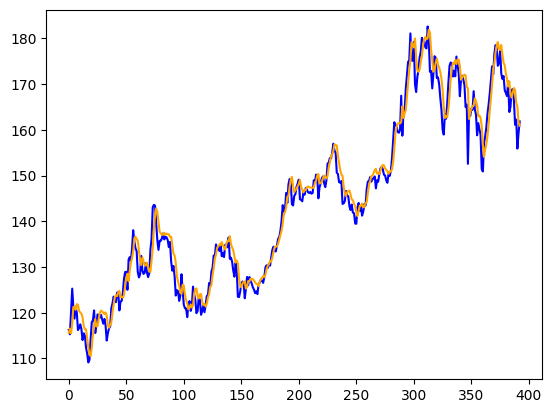

In [19]:
from sklearn.svm import SVR

parameter_grid = {'kernel':['rbf', 'linear', 'poly'],
                  'degree':list(range(3,6)),
                  'C': [2],
                  'shrinking':[True, False],
                  }
svm_model = SVR()
svm_model, svm_y_pred = grid_search_no_cv(model=svm_model, param_grid=parameter_grid)
pickle.dump(svm_model, open("svm_model.txt",'wb'))


plt.plot(list(range(svm_y_pred.shape[0])), y_val, 'blue', list(range(svm_y_pred.shape[0])), svm_y_pred, 'orange')


In [20]:
svm_model.get_params()

{'C': 2,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 5,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'shrinking': False,
 'tol': 0.001,
 'verbose': False}

In [21]:
print(f"RMSE: {root_mean_squared_error(y_pred=svm_y_pred, y_true=y_val)}")

RMSE: 3.234444441348808


## Gradient boosting using XGBoost

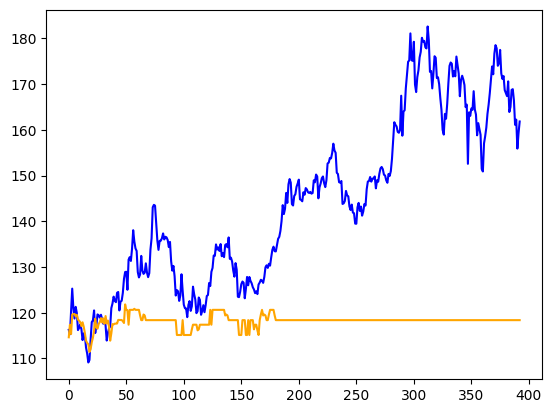

In [22]:
from xgboost import XGBRegressor

param_grid = {
    'objective':['reg:squarederror'],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'alpha': [5, 10, 15]
}

xgbr_model = XGBRegressor()

xgbr_model, xgbr_y_pred = grid_search_no_cv(model=xgbr_model, param_grid=param_grid)
pickle.dump(xgbr_model, open('xgbr_model', 'wb'))

plt.plot(list(range(xgbr_y_pred.shape[0])), y_val, 'blue', list(range(xgbr_y_pred.shape[0])), xgbr_y_pred, 'orange')


In [26]:
xgbr_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.7,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'alpha': 15}

In [27]:
print(f"RMSE: {root_mean_squared_error(y_pred=xgbr_y_pred, y_true=y_val)}")

RMSE: 31.369108573317806


## LSTM

In [23]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Input
# from keras.losses import MeanSquaredError



# lstm_model = Sequential([
#     Input(input_shape=[X_train.shape[1],1]),
#     LSTM(100, activation='relu'),
#     LSTM(50, activation='relu'), 
#     Dense(16, activation='relu'),
#     Dense(1,activation='relu')
# ])

# lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# lstm_model.summary()

In [24]:
# history = lstm_model.fit(X_train, y_train)
# lstm_y_pred = history.predict(X_val)


# Evaluate model

In [25]:
def plot_pred_vs_actual(y_pred, y_true):
    plt.plot(list(range(y_true)), y_true, 'blue', list(range(y_pred.shape[0])), y_pred, 'orange')
